In [11]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import itertools
import glob
from importlib import reload
import logging
from pathlib import Path
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import pickle
import random
from pandas import *

sys.path.append('..')
from tsfewshot.config import Config
from tsfewshot import plot, analyses
import random

np.random.seed(0)
torch.random.manual_seed(0)
random.seed(0)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
DEVICE = 'cuda:0'
base_run_dir = Path('./supervised/').resolve().absolute()

In [13]:
split = 'train'
support_sizes = {'miniimagenet_s': [5]}

runs = {}
tasks = {}
configs = {}
best_ft_options = {}
best_ft_epochs = {}
metrics = {}
results_df = {}
gridsearch_results = {}

## Define Datasets

In [14]:
test_classes = ['n02110341',
                'n07613480',
                'n04149813',
                'n02099601',
                'n02871525',
                'n02116738',
                'n02443484',
                'n03127925',
                'n04146614',
                'n03544143',
                'n03272010',
                'n02219486',
                'n01930112',
                'n02129165',
                'n04418357',
                'n03775546',
                'n01981276',
                'n03146219',
                'n02110063',
                'n04522168']
val_classes = ['n03017168',
              'n07697537',
              'n02108915',
              'n02113712',
              'n02120079',
              'n04509417',
              'n02089867',
              'n03888605',
              'n04258138',
              'n03347037',
              'n02606052',
              'n06794110']
train_classes = ['n07747607',
                'n03400231',
                'n02074367',
                'n01910747',
                'n04596742',
                'n03047690',
                'n07697537',
                'n13054560',
                'n02108551',
                'n04243546',
                'n02108915',
                'n04443257',
                'n04604644',
                'n13133613',
                'n02795169',
                'n04067472',
                'n04296562',
                'n02089867',
                'n03854065',
                'n03888605',
                'n03207743',
                'n04275548',
                'n03347037',
                'n02111277',
                'n03062245',
                'n03017168',
                'n01704323',
                'n07584110',
                'n02108089',
                'n04515003',
                'n02091831',
                'n01558993',
                'n02747177',
                'n02606052',
                'n09246464',
                'n03924679',
                'n04509417',
                'n03337140',
                'n03220513',
                'n04258138',
                'n01749939',
                'n04612504',
                'n02120079',
                'n02966193',
                'n01532829',
                'n06794110',
                'n03838899',
                'n02113712',
                'n01843383',
                'n02105505',
                'n04389033',
                'n03908618',
                'n04435653',
                'n02101006',
                'n02165456',
                'n03476684',
                'n02687172',
                'n03676483',
                'n01770081',
                'n02823428',
                'n02457408',
                'n03527444',
                'n03998194',
                'n04251144']

train_s_classes = ['n03017168',
                  'n07697537',
                  'n02108915',
                  'n02113712',
                  'n02120079',
                  'n04509417',
                  'n02089867',
                  'n03888605',
                  'n04258138',
                  'n03347037',
                  'n02606052',
                  'n06794110']

## Pretraining run:

`python tsfewshot/run.py train --config-file experiments/miniimagenet/configs/supervised_mini_imagenet_s-config.yml --gpu 0`

## Create configs for finetuning runs (from which we'll get the trajectories for SubGD's preconditioning matrix)

In [22]:
runs['miniimagenet_s'] = [base_run_dir / 'miniimagenet_s' / 'ms-s-sv-adam-seed1_pretraining_CV_220223_090821']  # adapt experiment name
configs['miniimagenet_s'] = Config(runs['miniimagenet_s'][0] / 'config.yml')
all_tasks = sorted([list(c) for c in set(tuple(sorted(t)) for t in itertools.combinations(train_classes, 5))])

In [6]:
all_tasks

[['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01770081'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01843383'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01910747'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02074367'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02089867'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02091831'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02101006'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02105505'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02108089'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02108551'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02108915'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02111277'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02113712'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n02120079'],
 ['n01532829', 'n01558993', 'n01704323', 'n01749

In [10]:
random.shuffle(all_tasks)
finetune_tasks = all_tasks
n_tasks = len(finetune_tasks)
tasks['miniimagenet_s'] = finetune_tasks[:1024]  # define number of tasks, i.e. trajectories
len(tasks['miniimagenet_s']), tasks['miniimagenet_s']

(1024,
 [['n01843383', 'n02105505', 'n03220513', 'n04515003', 'n09246464'],
  ['n01558993', 'n02091831', 'n02687172', 'n03337140', 'n04509417'],
  ['n02105505', 'n02823428', 'n03017168', 'n03337140', 'n03676483'],
  ['n02108915', 'n02606052', 'n03337140', 'n03854065', 'n04243546'],
  ['n02074367', 'n02108089', 'n02108915', 'n02747177', 'n04251144'],
  ['n02108551', 'n03476684', 'n03676483', 'n03888605', 'n09246464'],
  ['n02108089', 'n02111277', 'n02687172', 'n03838899', 'n03998194'],
  ['n03337140', 'n03527444', 'n04243546', 'n04275548', 'n13133613'],
  ['n01532829', 'n03347037', 'n03838899', 'n04251144', 'n04515003'],
  ['n02074367', 'n03998194', 'n04067472', 'n04243546', 'n07584110'],
  ['n03047690', 'n03062245', 'n03527444', 'n04251144', 'n04604644'],
  ['n01532829', 'n02795169', 'n03838899', 'n04251144', 'n04275548'],
  ['n02108089', 'n03017168', 'n04389033', 'n04604644', 'n07697537'],
  ['n02074367', 'n02165456', 'n03998194', 'n04443257', 'n04515003'],
  ['n02113712', 'n02457408'

In [ ]:
additional_args = """
classification_n_classes:
 train: 64
 finetune: 5
"""
base_dir = './data/miniImagenet'  # miniimagenet directory
analyses.create_finetune_configs(runs['miniimagenet_s'], tasks['miniimagenet_s'], lr=0.001,save_every=1,additional_args=additional_args, suffix='_n_task1train_orig')

### Multiple fine tune runs:

`python tsfewshot/run_scheduler.py finetune --directory experiments/miniimagenet/supervised/miniimagenet_s/ms-s-sv-adam-seed1_pretraining_CV_220223_090821/finetune_pca_epoch_lr0.001/configs --gpu-ids 0 1 --runs-per-gpu 4`

### Calculate autocorrelation matrix:

`python pca.py --base-dir experiments/miniimagenet/supervised/miniimagenet_s/ms-s-sv-adam-seed1_pretraining_CV_220223_090821/ --finetune-dirs experiments/miniimagenet/supervised/miniimagenet_s/ms-s-sv-adam-seed1_pretraining_CV_220223_090821/finetune_pca_epoch_lr0.001/ms-s* --reduce-classification-head 5`

## Check out autocorrelation matrix

In [15]:
# load pca
path_to_pca = base_run_dir / "miniimagenet_s/ms-s-sv-adam-seed1_pretraining_CV_220223_090821/pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNone.p"
pca=pickle.load(open(path_to_pca, "rb"))
print(pca.keys())

pca_file = Path(path_to_pca)
if pca_file.exists():
    with pca_file.open('rb') as pf:
        p = pickle.load(pf)


dict_keys(['u', 's', 'v', 'explained_variance', 'deltas_mean'])


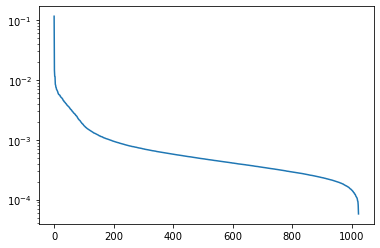

In [16]:
# plot explained variance
plt.figure()
plt.yscale('log')
svals_data = p['s'].detach()
eigvals_data = svals_data**2 / (svals_data.shape[0] - 1)
plt.plot(eigvals_data / eigvals_data.sum())

## Define LRs for grid search

In [17]:
ft_lrs = [1.0,  0.1, 0.001, 0.0001,1e-5,1e-6]
inner_seeds = [0]  # seeds for gridsearch
inner_seeds_final = [0]  # seeds for final finetuning
type_specs = [
    'normal',  # normal finetuning without PCA
    'pca'  # finetuning with PCA
]

def combinations(support: int):
    """Generates combinations from the grid search. """
    combinations = []
    for type_spec in type_specs:
        lrs = copy.copy(ft_lrs)
        for lr in lrs:
            combinations.append({'support': support, 'lr': lr, 'type': type_spec, 'sparsity': None, 'noise': 0.0, 'interpolate': 1.0})
    return combinations
    
len(combinations(5))

12

## Create grid search configs

In [19]:
runs['miniimagenet_s'] = [base_run_dir / 'miniimagenet_s' / d for d in ['ms-s-sv-adam-seed1_pretraining_CV_220223_090821']]

In [ ]:
# conventional grid search: on val set
for run in runs['miniimagenet_s']:
    for support in support_sizes['miniimagenet_s']:
        new_dirs = analyses.create_gridsearch_dirs(run, combinations(support=support),
                                                   'gridSearch4LRs',
                                                   inner_seeds=inner_seeds,
                                                   n_trajectories=None,
                                                   query_size=999999,
                                                   ft_epochs={lr: 300 for lr in ft_lrs},
                                                   eval_every=list(range(50)) + list(range(50, 1001, 10)),
                                                   patience=None,
                                                   val_datasets=val_classes,  # use validation classes from dataset
                                                   optimizer='adam-squared',
                                                   n_dataset_evals=20,  # 20 episodes
                                                   is_label_shared=False,
                                                   pca_file_path=run.absolute() / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNone.p',
                                                   classification_n_classes={'train': 64, 'finetune': 5})
        print([d.name + '\n' for d in new_dirs if 'seed0' in d.name])

## Run grid search
`python ./tsfewshot/run_scheduler.py eval --directory experiments/miniimagenet/supervised/miniimagenet_s/ms-s-sv-adam-seed1_pretraining_CV_220223_090821/gridSearch4LRs --name-filter pca --split val --epoch -1 --gpu-ids 0 1 --runs-per-gpu 4`

## Evaluate Grid Search

In [20]:
best_ft_options['miniimagenet_s'] = {}
best_ft_epochs['miniimagenet_s'] = {}
gridsearch_results['miniimagenet_s'] = {}
for run in runs['miniimagenet_s']:
    new_run_dirs, best_ft_options['miniimagenet_s'][run], best_ft_epochs['miniimagenet_s'][run], gridsearch_results['miniimagenet_s'][run] = \
        analyses.create_final_finetune_dirs([run],
                                            support_sizes=support_sizes['miniimagenet_s'],
                                            combinations=list(itertools.chain(*[combinations(i) for i in support_sizes['miniimagenet_s']])),
                                            gridsearch_seeds=inner_seeds,
                                            inner_seeds=inner_seeds_final,
                                            gridsearch_dir='gridSearch4LRs',
                                            test_tasks=test_classes,
                                            best_ft_options=None, best_ft_epochs=None,
                                            n_results=20,
                                            metric_name='accuracy',
                                            metric_aggregation='mean'
                                            n_dataset_evals=100,
                                            split='test')
    display([r.name for r in new_run_dirs])

5
support size: 5    normal noise 0.0                                                                 LR: 0.0001 epochs: 35   
support size: 5    pca noise 0.0                                                                    LR: 0.0001 epochs: 130  


[]

## Run Final Finetunes
`python ./tsfewshot/run_scheduler.py eval --directory experiments/miniimagenet/supervised/miniimagenet_s/ms-s-sv-adam-seed1_pretraining_CV_220223_090821/gridSearch4LRs_finalFinetune --split test --epoch -1 --gpu-ids 0 1 --runs-per-gpu 4`

## Get Final Metrics

In [23]:
metrics['miniimagenet_s'] = {}
results_df['miniimagenet_s'] = {}
split='test'
for run in runs['miniimagenet_s']:
    metrics['miniimagenet_s'][run] = \
        analyses.get_final_metrics([run],
                                    noises=[0.0],
                                    support_sizes=support_sizes['miniimagenet_s'],
                                    combinations=list(itertools.chain(*[combinations(i) for i in support_sizes['miniimagenet_s']])),
                                    best_ft_options=best_ft_options['miniimagenet_s'][run],
                                    inner_seeds=inner_seeds_final,
                                    query_size=configs['miniimagenet_s'].query_size,
                                    n_trajectories=None,
                                    test_tasks=configs['miniimagenet_s'].val_datasets if split == 'val' else configs['miniimagenet_s'].test_datasets,
                                    gridsearch_dir='gridSearch4LRs',
                                    metrics=None,
                                    split='test',
                                    device=DEVICE,
                                    init_epoch=None,
                                    metric_name='accuracy',
                                    metric_aggregation='mean',
                                    metric_file_name='accuracy',
                                    no_ft_eval=False)
    results_df['miniimagenet_s'][run] = pd.DataFrame({k: v['accuracy'] for k, v in metrics['miniimagenet_s'][run][0.0].items()}, dtype=float)
    results_df['miniimagenet_s'][run].columns.names = ['support', 'type', 'seed']

5


In [24]:
from scipy.stats import wilcoxon
results_df['miniimagenet_s'][run].head()
n = results_df['miniimagenet_s'][run].to_numpy()
w, p = wilcoxon(n[:,0],n[:,1])
w, p

(1365.0, 6.649789739651983e-05)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  1.6min finished
100%|██████████| 3/3 [00:43<00:00, 14.46s/it]


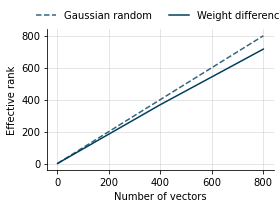

In [25]:
# erank plot
plt.figure(figsize=(4, 3))
finetune_dirs = list((run / f'finetune_pca_epoch_lr0.001').glob('ms-s-sv-adam-seed1*/'))  # paths to your finetune dirs
cfg = Config(run / 'config.yml')

f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                            tols=[0],
                            ax=plt.gca(),
                            random_baseline=True,
                            n_repeats=1, 
                            task_steps=100,  # the smaller this number, the longer it takes!
                            within_task_steps=None,
                            epoch_steps=None,
                            use_erank=True,
                            colors=['#003f5c'],
                            plot_details=False,
                            plot_val_metric=False,
                            reduce_head=5)
plt.tight_layout()
plt.savefig(f'erank_miniimagenet.pdf', bbox_inches='tight')